In [ ]:
import numpy as np
import json
import yaml
import matplotlib.pyplot as plt
import py_sc_fermi
import py_sc_fermi.dos
from py_sc_fermi.defect_charge_state import DefectChargeState
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.defect_system import DefectSystem
from pymatgen.core import Structure
from pydefect.chem_pot_diag.chem_pot_diag import ChemPotDiagMaker, RelativeEnergies, CpdAbstractEnergies
from pydefect.chem_pot_diag.cpd_plotter import ChemPotDiag3DMplPlotter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from vise.util.sort_coords import sort_coords
from pydefect.analyzer.defect_energy import DefectEnergy, DefectEnergies, DefectEnergySummary
from pydefect.analyzer.defect_energy_plotter import DefectEnergyMplPlotter

In [ ]:
folder_ = './BCP/unitcell/'
dos_vasp = py_sc_fermi.dos.DOS.from_vasprun(folder_ + '/vasprun.xml', 44)
structure = Structure.from_file(folder_ + 'CONTCAR')
volume = structure.volume

def defect_concentration(states, temp=1000, f_level=None, print_intrinsic=None):
    c1, c2, c3 = states
    charge_1, formation_1 = c1
    charge_2, formation_2 = c2
    charge_3, formation_3 = c3

    P_Cd_0 = DefectChargeState(charge=charge_1, degeneracy=2, energy=formation_1)
    P_Cd_n_1 = DefectChargeState(charge=charge_2, degeneracy=2, energy=formation_2)
    P_Cd_p_1 = DefectChargeState(charge=charge_3, degeneracy=2, energy=formation_3)

    P_Cd = DefectSpecies(name="P_Cd", nsites=2,  charge_states={charge_1:P_Cd_0, charge_2:P_Cd_n_1, charge_3:P_Cd_p_1})
    defect_system = DefectSystem(defect_species=[P_Cd], dos=dos_vasp, volume=volume, temperature=temp)

    intrinsic_fermi_energy = defect_system.get_sc_fermi()[0]

    if print_intrinsic:
        p0 = dos_vasp.carrier_concentrations(intrinsic_fermi_energy, 1000)[0] * 1e24 / defect_system.volume
        n0 = dos_vasp.carrier_concentrations(intrinsic_fermi_energy, 1000)[1] * 1e24 / defect_system.volume

        print(n0, p0)

    if f_level == None:
        conc = P_Cd.get_concentration(e_fermi=intrinsic_fermi_energy, temperature=temp) * 1e24 / defect_system.volume

    else:
        conc = P_Cd.get_concentration(e_fermi=f_level, temperature=temp) * 1e24 / defect_system.volume

    return conc

defect_concentration([(0, 300.6), (-1, 400.2), (1, 200.8)])

0.0

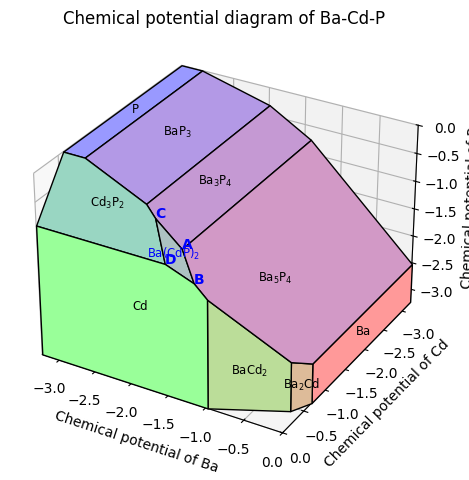

In [ ]:
target_vertices_yaml = ".BCP/cpd/target_vertices.yaml"
relative_energies_yaml = ".BCP/cpd/relative_energies.yaml"
standard_energies_yaml = ".BCP/cpd/standard_energies.yaml"

with open(target_vertices_yaml) as stream:
    target_vertices_data = yaml.safe_load(stream)
with open(relative_energies_yaml) as stream:
    relative_energies_data = yaml.safe_load(stream)
with open(standard_energies_yaml) as stream:
    standard_energies_data = yaml.safe_load(stream)

cpd_3d = ChemPotDiagMaker(relative_energies=RelativeEnergies(CpdAbstractEnergies(relative_energies_data)), 
                 elements=["Ba", "Cd", "P"], target="Ba(CdP)2").chem_pot_diag

class mod_ChemPotDiag3DMplPlotter(ChemPotDiag3DMplPlotter):
    def draw_simplex(self, formula):

        vertex_coords = self.cpd.polygons[formula]


        face = Poly3DCollection([sort_coords(np.array(vertex_coords))])
        
        if formula == "Ba(CdP)2":
            face.set_cmap('jet')
        else:
            face.set_color([1, 1, 1])

        face.set_edgecolor("black")
        self._ax.add_collection3d(face)

plotter = ChemPotDiag3DMplPlotter(cpd_3d)
plotter.draw_diagram().show()


In [ ]:
f = open('defect_energy_summary.json')
data = json.load(f)

def json_to_object(json_dict):
    def convert_defect_energy(de):
        return DefectEnergy(
            formation_energy=de["formation_energy"],
            energy_corrections=de["energy_corrections"],
            is_shallow=de["is_shallow"]
        )

    def convert_defect_energies(de):
        return DefectEnergies(
            atom_io=de["atom_io"],
            charges=de["charges"],
            defect_energies=[convert_defect_energy(e) for e in de["defect_energies"]]
        )

    return DefectEnergySummary(
        title=json_dict["title"],
        defect_energies={key: convert_defect_energies(val) for key, val in json_dict["defect_energies"].items()},
        rel_chem_pots=json_dict["rel_chem_pots"],
        cbm=json_dict["cbm"],
        supercell_vbm=json_dict["supercell_vbm"],
        supercell_cbm=json_dict["supercell_cbm"]
    )

defect_energy_summary = json_to_object(data)

   INFO: -- Settings from vise.yaml:
   INFO: 
   INFO: -- Settings from pydefect.yaml:
   INFO: 


In [ ]:
def get_conc_at_fermi(defect_energy_summary_object, x, y, z, fermi_level, defect_id='P_Cd', x_id='Ba', y_id='Cd', z_id='P'):
    defect_energy_summary_object.rel_chem_pots["A-temp"] = {x_id: x, y_id: y, z_id: z}
    f = defect_energy_summary_object.charge_energies("A-temp", True, True, (0, defect_energy_summary_object.cbm))
    f = f.charge_energies_dict[defect_id].charge_energies_at_ef(0)

    dn = 1e14
    c_tot = 2.7702148555831E-07

    return defect_concentration(f, temp=1000, f_level=None) * c_tot * dn

get_conc_at_fermi(defect_energy_summary, x=-2.75, y=-0.22413, z=-0.06256, fermi_level=0.72) 


2.6782964368248066e+19

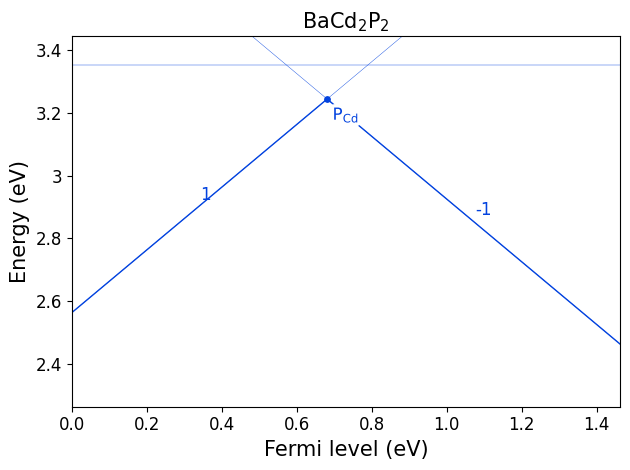

In [ ]:
plotter = DefectEnergyMplPlotter(
    defect_energy_summary=defect_energy_summary,
    chem_pot_label="D",
    allow_shallow=True,
    with_corrections=True,
    add_thin_lines=True)
plotter.construct_plot()
plotter.plt.show()

In [ ]:
vertices = np.array(cpd_3d.polygons['Ba(CdP)2'])

x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

grid_x, grid_y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

additional_polygons = [cpd_3d.polygons[i] for i in cpd_3d.polygons.keys()]

fermis_t = 0.7
grid_intensity = []
for xi, yi, zi in zip(grid_x, grid_y, grid_z):
    row = []
    for xe, ye, ze in zip(xi, yi, zi):
        if ze != ze:
            row.append(get_conc_at_fermi(defect_energy_summary, x[0], y[0], z[0], fermis_t))
        else:
            row.append(get_conc_at_fermi(defect_energy_summary, xe, ye, ze, fermis_t))
    grid_intensity.append(row)
grid_intensity = np.array(grid_intensity)

In [26]:
np.max(grid_intensity), np.min(grid_intensity)

(12727968635388.246, 12727968635388.246)

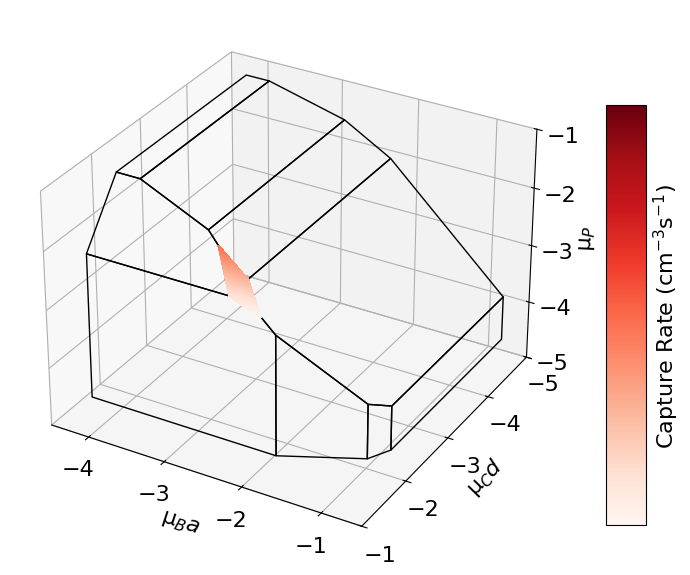

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

norm_intensity = (grid_intensity - np.min(grid_intensity)) / (np.max(grid_intensity) - np.min(grid_intensity))


poly3d = [sort_coords(np.array(i)) for i in additional_polygons]
collection = Poly3DCollection(poly3d, linewidths=1)
collection.set_edgecolor('black')
collection.set_facecolor([1, 1, 1, 0])
collection.set_zorder(1) 

fig = plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16, 'figure.figsize': (8, 6)})
plt.rcParams['font.family'] = 'sans-serif'

ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(collection)

norm = LogNorm(vmin=1e13, vmax=1e23)
ax.plot_surface(grid_x, grid_y, grid_z, facecolors=plt.cm.Reds(norm(grid_intensity)), rstride=1, cstride=1, antialiased=False, shade=False, zorder=2)

cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.7])  
m = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
m.set_array(grid_intensity)
colorb = fig.colorbar(m, cax=cbar_ax, label='Capture Rate ($\mathsf{cm^\mathsf{-3}}$$\mathsf{s^\mathsf{-1}}$)')
colorb.ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='all'))
colorb.ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all'))

ax.set_xlim(-4.5, -0.5)
ax.set_ylim(-1, -5)
ax.set_zlim(-5, -1)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.zaxis.set_major_locator(plt.MultipleLocator(1))

ax.set_xlabel('µ$_Ba$')
ax.set_ylabel('µ$_Cd$')
ax.set_zlabel('µ$_P$')

plt.tight_layout()
plt.savefig('P_Cd.svg', format='svg', transparent=True)
plt.show()

